## (1) DataFrame 생성

In [2]:
import os
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [3]:
import pandas as pd

fname = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(fname, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])
irisDf = spark.createDataFrame(iris)

## (2) 회귀선 그래프

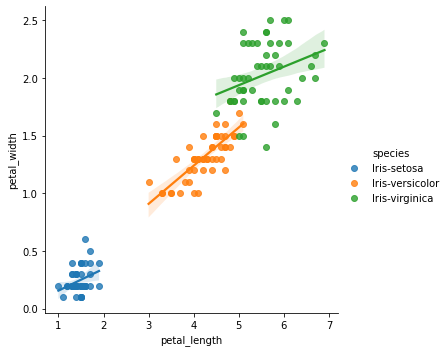

In [4]:
import seaborn as sns

sns.lmplot(x="petal_length", y="petal_width", data=iris, hue="species")

##  (3) Spark를 사용하여 회귀분석하고 계수 출력

In [6]:
(trainDf, testDf) = irisDf.randomSplit([0.6, 0.4])
trainDf.count()

82

In [7]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol="species", outputCol="speciesIndex")

In [8]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="speciesIndex", outputCol="speciesVec")

In [9]:
from pyspark.ml.feature import VectorAssembler
va = VectorAssembler(inputCols = ["speciesVec","petal_length"],
                                   outputCol = 'features')

In [10]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = "features", labelCol="petal_length", maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [11]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[stringIndexer, encoder, va, lr])

In [12]:
model = pipeline.fit(trainDf)
modelTrainDf = model.transform(trainDf)

In [13]:
print("Coefficients: {}".format(model.stages[-1].coefficients))
print("Intercept: {:.3f}".format(model.stages[-1].intercept))

Coefficients: [-0.46151585252431654,0.035400505417527164,0.7303669322702501]
Intercept: 1.133


## (4) 실제와 예측 출력

In [14]:
modelTestDf=model.transform(testDf)

In [15]:
modelTestDf.select("petal_length","prediction").show(10)

+------------+------------------+
|petal_length|        prediction|
+------------+------------------+
|         1.3|1.6210841647235126|
|         1.3|1.6210841647235126|
|         1.6|1.8401942444045876|
|         1.6|1.8401942444045876|
|         4.5|4.4551747059301565|
|         1.5|1.7671575511775626|
|         1.5|1.7671575511775626|
|         1.4|1.6941208579505374|
|         1.5|1.7671575511775626|
|         1.6|1.8401942444045876|
+------------+------------------+
only showing top 10 rows



## (4) 정확성 평가하고 출력

In [16]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="rmse")

In [17]:
rmse=evaluator.evaluate(modelTestDf)

In [18]:
f"Root Mean Squared Error (RMSE) on test data: {rmse:.3f}"

'Root Mean Squared Error (RMSE) on test data: 0.246'

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator=RegressionEvaluator(labelCol="petal_length", predictionCol="prediction", metricName="r2")

In [22]:
f"r2: {evaluator.evaluate(modelTestDf):.3f}"

'r2: 0.976'